In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import torch
import sys
from helpers_task_detector import *
sys.path.append('../')
from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
experiment_name = 'Experiment52'
path_results = './Results/' + experiment_name

In [3]:
path_to_hnets = './Models/Models_HNET'
data_path = './Data/Sim_Data_'+'Experiment18'+'.pkl'

#models_exp = np.sort(os.listdir(os.path.join(path_to_hnets, experiment_name)))

with open(os.path.join(data_path), 'rb') as fp:
    data = pickle.load(fp)

In [4]:
data.keys()

dict_keys(['Data_4_2', 'Data_1_1', 'Data_0_2', 'Data_1_2', 'Data_0_1', 'Data_3_1', 'Data_4_1', 'Data_2_1', 'Data_2_2', 'Data_3_2'])

In [5]:
with open(os.path.join(path_results +'.pkl'), 'rb') as fp:
    results = pickle.load(fp)

In [6]:
results.keys()

dict_keys(['Data_4_2', 'Data_1_1', 'Data_0_2', 'Data_1_2', 'Data_0_1', 'Data_3_1', 'Data_4_1', 'Data_2_1', 'Data_2_2', 'Data_3_2'])

In [7]:
dataset = []
r2_test_detector = []
r2_test_hnet = []
y_true_detector = []
y_pred_detector = []
y_true_hnet = []
y_pred_hnet = []
predicted_task = []
new_task = []
max_id = 0
found_ids = []
true_task = []

true_task_map = {}
for d in data.keys():
    new_id = d.split('_')[1]
    if new_id not in found_ids:
        found_ids.append(new_id)
        true_task_map[d] = max_id
        max_id += 1
    else:
        idx_id = found_ids.index(new_id)
        true_task_map[d] = idx_id

In [8]:
true_task_map

{'Data_4_2': 0,
 'Data_1_1': 1,
 'Data_0_2': 2,
 'Data_1_2': 1,
 'Data_0_1': 2,
 'Data_3_1': 3,
 'Data_4_1': 0,
 'Data_2_1': 4,
 'Data_2_2': 4,
 'Data_3_2': 3}

In [9]:
for set in results.keys():
    dataset.append(set)
    r2_test_detector.append(results[set]['r2_test_detector'])
    r2_test_hnet.append(results[set]['r2_test_hnet'])
    predicted_task.append(results[set]['predicted_task'])
    new_task.append(results[set]['new_task'])
    true_task.append(true_task_map[set])
    if 'y_true_hnet' in results[set].keys():
        y_true_hnet.append([results[set]['y_true_hnet']])
        y_pred_hnet.append([results[set]['y_pred_hnet']])
    else:
        y_true_hnet.append([0])
        y_pred_hnet.append([0])
    if 'y_true_detector' in results[set].keys():
        y_true_detector.append([results[set]['y_true_detector']])
        y_pred_detector.append([results[set]['y_pred_detector']])
    else:
        y_true_detector.append([0])
        y_pred_detector.append([0])

In [10]:
df = pd.DataFrame({'Dataset':dataset,
                   'True_Task': true_task,
                   'Predicted_Task' : predicted_task,
                   'New_Task': new_task, 
                    'Y_t_detector': y_true_detector,
                    'Y_p_detector':y_pred_detector,  
                    'R2_Detector':r2_test_detector,
                    'Y_t_hnet': y_true_hnet,
                    'Y_p_hnet':y_pred_hnet,  
                    'R2_hnet':r2_test_hnet})

In [11]:
df

,Dataset,True_Task,Predicted_Task,New_Task,Y_t_detector,Y_p_detector,R2_Detector,Y_t_hnet,Y_p_hnet,R2_hnet
0,Data_4_2,0,0,True,"[[[-0.5063821, -2.0975661], [-0.5946211, -2.02...","[[[-1.4734743, -1.0329686], [-0.8245103, -0.95...",0.877721,"[[[[-0.50638213 -2.09756602], [-0.5946211 -2....","[[[[-1.6264524 -5.328743 ], [ 0.13379765 -0.36...",0.822910
1,Data_1_1,1,1,True,"[[[0.87900066, 0.94454104], [0.46398437, 0.702...","[[[-0.24742216, -0.5577869], [-0.28442162, -0....",0.821835,"[[[[0.87900067 0.94454102], [0.46398438 0.7024...","[[[[1.455179 0.8577696], [0.07180935 3.13142 ...",0.808761
2,Data_0_2,2,2,True,"[[[-0.5063821, -2.0975661], [-0.5946211, -2.02...","[[[-1.6579056, -1.1060923], [-0.9935086, -1.07...",0.880459,"[[[[-0.50638213 -2.09756602], [-0.5946211 -2....","[[[[-0.810214 -1.5220279], [-1.1945932 -3.670...",0.837598
3,Data_1_2,1,1,False,[0],[0],0.832976,"[[[[-0.50638213 -2.09756602], [-0.5946211 -2....","[[[[-2.8210561 -0.4822928], [-0.1096178 -1.519...",0.821565
4,Data_0_1,2,2,False,[0],[0],0.877569,"[[[[0.87900067 0.94454102], [0.46398438 0.7024...","[[[[0.4183777 0.28284818], [ 1.5897624 -1.929...",0.820246
5,Data_3_1,3,3,True,"[[[0.87900066, 0.94454104], [0.46398437, 0.702...","[[[-0.44153327, -0.59841555], [-0.16456914, -0...",0.844642,"[[[[0.87900067 0.94454102], [0.46398438 0.7024...","[[[[-0.13504583 -0.04545975], [ 0.86170775 -0....",0.826920
6,Data_4_1,0,0,False,[0],[0],0.868385,"[[[[0.87900067 0.94454102], [0.46398438 0.7024...","[[[[ 3.6075146 -1.2737685], [9.44343 0.3862...",0.391419
7,Data_2_1,4,4,True,"[[[0.87900066, 0.94454104], [0.46398437, 0.702...","[[[0.29603106, -0.64882636], [0.1131763, -0.30...",0.867932,"[[[[0.87900067 0.94454102], [0.46398438 0.7024...","[[[[ 0.7724571 -0.94527084], [ 0.87680566 -1....",0.842620
8,Data_2_2,4,4,False,[0],[0],0.880429,"[[[[-0.50638213 -2.09756602], [-0.5946211 -2....","[[[[-4.1128874 -2.318667 ], [-3.2662764 0.289...",0.849858
9,Data_3_2,3,3,False,[0],[0],0.868114,"[[[[-0.50638213 -2.09756602], [-0.5946211 -2....","[[[[1.4322516 0.35129684], [-0.36700284 0.61...",0.846658


### Assess continual learning on hypernetwork

The idea here is to load all hypernets, after each task has been learned, and then test for each model on the trained task + all the previously seen tasks.

In [12]:
path_to_hnets = './Models/Models_HNET'

models_exp = np.sort(os.listdir(os.path.join(path_to_hnets, experiment_name)))

with open(os.path.join(data_path), 'rb') as fp:
    data = pickle.load(fp)

In [13]:
data.keys()

dict_keys(['Data_4_2', 'Data_1_1', 'Data_0_2', 'Data_1_2', 'Data_0_1', 'Data_3_1', 'Data_4_1', 'Data_2_1', 'Data_2_2', 'Data_3_2'])

### Change and add here the true task to know which model to use

In [14]:
model = []
test_set = []
r2_list = []
data_name = []
for i,m in enumerate(models_exp):
    model_i = torch.load(os.path.join(path_to_hnets,experiment_name, m))
    for task,set in zip(df.True_Task, df.Dataset):
        perturbed_task = set.split('_')[1]

        if perturbed_task == '0':
            name = 'Baseline'
        elif perturbed_task == '1':
            name = 'Removed Neurons'    
        elif perturbed_task == '2':
            name = 'Shuffled Neurons'
        elif perturbed_task == '3':
            name = 'Gain' 
        elif perturbed_task == '4':
            name = 'Offset'

        print('True Task', task)
        if task <= i :
            W = model_i(cond_id = task)
            main_net = RNN_Main_Model(num_features= 130, hnet_output = W,  hidden_size = 300,
                                num_layers= 1,out_dims=2,  
                                dropout= 0.2,  LSTM_ = False)
            x_train, y_train, x_val, y_val, x_test, y_test = data[set]
            r2, _ = calc_explained_variance_mnet(x_test, y_test, W, main_net)
            model.append(m)
            test_set.append(set)
            r2_list.append(r2)
            data_name.append(name)    

True Task 0
True Task 1
True Task 2
True Task 1
True Task 2
True Task 3
True Task 0
True Task 4
True Task 4
True Task 3
True Task 0
True Task 1
True Task 2
True Task 1
True Task 2
True Task 3
True Task 0
True Task 4
True Task 4
True Task 3
True Task 0
True Task 1
True Task 2
True Task 1
True Task 2
True Task 3
True Task 0
True Task 4
True Task 4
True Task 3
True Task 0
True Task 1
True Task 2
True Task 1
True Task 2
True Task 3
True Task 0
True Task 4
True Task 4
True Task 3
True Task 0
True Task 1
True Task 2
True Task 1
True Task 2
True Task 3
True Task 0
True Task 4
True Task 4
True Task 3


In [15]:
df_plot = pd.DataFrame({ 'Model':model,
                    'Name' : data_name,
                    'Dataset':test_set,
                    'R2': r2_list})

In [16]:
df_plot

,Model,Name,Dataset,R2
0,Model_Task_0.pth,Offset,Data_4_2,0.819570
1,Model_Task_0.pth,Offset,Data_4_1,0.804503
2,Model_Task_1.pth,Offset,Data_4_2,0.388556
3,Model_Task_1.pth,Removed Neurons,Data_1_1,0.806953
4,Model_Task_1.pth,Removed Neurons,Data_1_2,0.820525
5,Model_Task_1.pth,Offset,Data_4_1,0.414278
6,Model_Task_2.pth,Offset,Data_4_2,0.388306
7,Model_Task_2.pth,Removed Neurons,Data_1_1,0.809913
8,Model_Task_2.pth,Baseline,Data_0_2,0.841506
9,Model_Task_2.pth,Removed Neurons,Data_1_2,0.820298


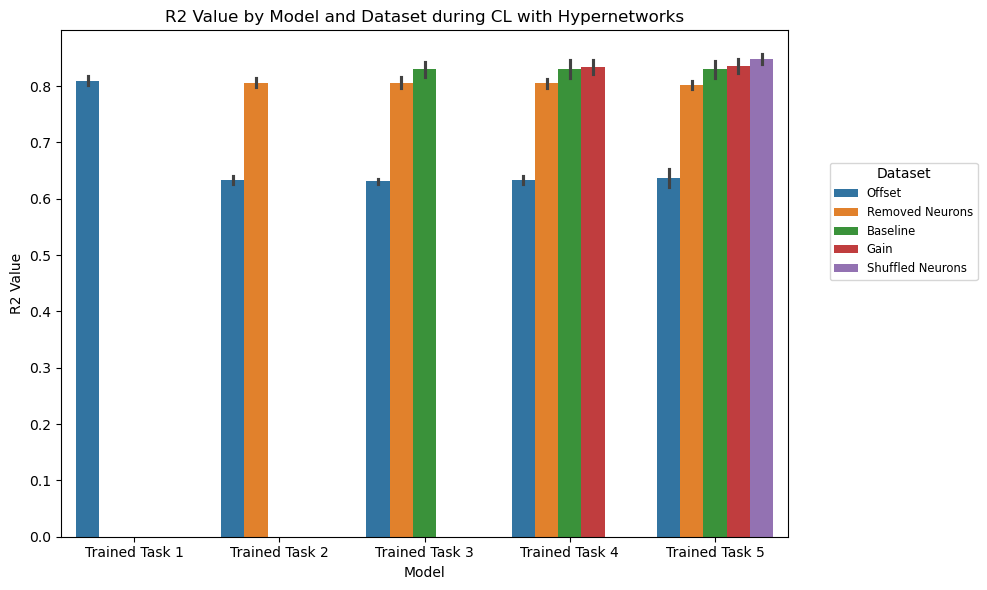

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the bar plot
plt.figure(figsize=(10, 6))

sns.barplot(data=df_plot, x='Model', y='R2', hue='Name')#, color = 'Name', ci=None)  # ci=None to remove confidence intervals

plt.title('R2 Value by Model and Dataset during CL with Hypernetworks')

plt.xlabel('Model')

plt.ylabel('R2 Value')

new_labels = ['Trained Task 1', 'Trained Task 2', 'Trained Task 3', 'Trained Task 4', 'Trained Task 5']  # New labels for x-axis

plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

""" legend_labels = ['Baseline 1', 'Baseline 1', 'Removed Neurons 1', 'Removed Neurons 2',
                 'Shuffled Neurons 1', 'Shuffled Neurons 1', 'Added Gain 1', 'Added Gain 2',
                 'Added Offset 1', 'Added Offset 2']  # New labels for legend """

plt.legend(title='Dataset', fontsize = 'small', 
        bbox_to_anchor=(1.05, 0.75),
        loc='upper left') 
        #labels=legend_labels)  # Move legend to upper left corner

plt.tight_layout()
plt.show()

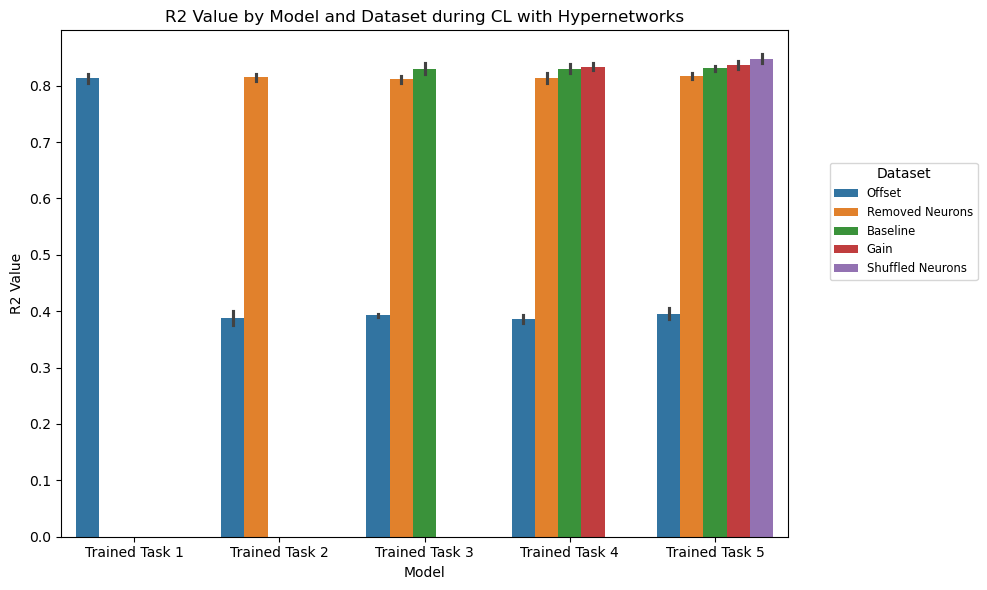

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the bar plot
plt.figure(figsize=(10, 6))

sns.barplot(data=df_plot, x='Model', y='R2', hue='Name')#, color = 'Name', ci=None)  # ci=None to remove confidence intervals

plt.title('R2 Value by Model and Dataset during CL with Hypernetworks')

plt.xlabel('Model')

plt.ylabel('R2 Value')

new_labels = ['Trained Task 1', 'Trained Task 2', 'Trained Task 3', 'Trained Task 4', 'Trained Task 5']  # New labels for x-axis

plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

""" legend_labels = ['Baseline 1', 'Baseline 1', 'Removed Neurons 1', 'Removed Neurons 2',
                 'Shuffled Neurons 1', 'Shuffled Neurons 1', 'Added Gain 1', 'Added Gain 2',
                 'Added Offset 1', 'Added Offset 2']  # New labels for legend """

plt.legend(title='Dataset', fontsize = 'small', 
        bbox_to_anchor=(1.05, 0.75),
        loc='upper left') 
        #labels=legend_labels)  # Move legend to upper left corner

plt.tight_layout()
plt.show()

In [73]:
data['Data_0_1'][0].shape

(54, 100, 130)

### Plot the accuracy of detection vs num of trials used

In [19]:
def create_task_map(data):
    found_ids = []
    max_id = 0
    true_task_map = {}
    for d in data.keys():
        new_id = d.split('_')[1]
        if new_id not in found_ids:
            found_ids.append(new_id)
            true_task_map[d] = max_id
            max_id += 1
        else:
            idx_id = found_ids.index(new_id)
            true_task_map[d] = idx_id
    return true_task_map

In [20]:
def create_table_results(experiment_name):
    dataset = []
    r2_test_detector = []
    r2_test_hnet = []
    y_true_detector = []
    y_pred_detector = []
    y_true_hnet = []
    y_pred_hnet = []
    predicted_task = []
    new_task = []
    true_task = []

    path_results = './Results/' + experiment_name
    
    with open(os.path.join(path_results +'.pkl'), 'rb') as fp:
        results = pickle.load(fp)
    
    data_path = './Data/Sim_Data_'+experiment_name+'.pkl'
    with open(os.path.join(data_path), 'rb') as fp:
        data = pickle.load(fp)
    true_task_map = create_task_map(data)
    for set in results.keys():
        dataset.append(set)
        r2_test_detector.append(results[set]['r2_test_detector'])
        r2_test_hnet.append(results[set]['r2_test_hnet'])
        predicted_task.append(results[set]['predicted_task'])
        new_task.append(results[set]['new_task'])
        true_task.append(true_task_map[set])
        if 'y_true_hnet' in results[set].keys():
            y_true_hnet.append([results[set]['y_true_hnet']])
            y_pred_hnet.append([results[set]['y_pred_hnet']])
        else:
            y_true_hnet.append([0])
            y_pred_hnet.append([0])
        if 'y_true_detector' in results[set].keys():
            y_true_detector.append([results[set]['y_true_detector']])
            y_pred_detector.append([results[set]['y_pred_detector']])
        else:
            y_true_detector.append([0])
            y_pred_detector.append([0])
        
    df = pd.DataFrame({'Dataset':dataset,
                   'True_Task': true_task,
                   'Predicted_Task' : predicted_task,
                   'New_Task': new_task, 
                    'Y_t_detector': y_true_detector,
                    'Y_p_detector':y_pred_detector,  
                    'R2_Detector':r2_test_detector,
                    'Y_t_hnet': y_true_hnet,
                    'Y_p_hnet':y_pred_hnet,  
                    'R2_hnet':r2_test_hnet}) 
    return df

In [21]:
exp_num_trials = {'Experiment7': 1, 
                  'Experiment8': 5,
                  'Experiment9': 10, 
                  'Experiment10': 15, 
                  'Experiment11': 20, 
                  'Experiment12': 25, 
                  'Experiment13': 30, 
                  'Experiment14': 35, 
                  'Experiment15': 40,
                  'Experiment16': 45, 
                  'Experiment17': 50,
                  'Experiment18': 54,
                  'Experiment19': 1, 
                  'Experiment20': 5,
                  'Experiment21': 10, 
                  'Experiment22': 15, 
                  'Experiment23': 20, 
                  'Experiment24': 25, 
                  'Experiment25': 30, 
                  'Experiment26': 35, 
                  'Experiment27': 1, 
                  'Experiment28': 5,
                  'Experiment29': 10, 
                  'Experiment30': 15, 
                  'Experiment31': 20, 
                  'Experiment32': 25, 
                  'Experiment33': 30, 
                  'Experiment34': 35, 
                  'Experiment35': 40,
                  'Experiment36': 45, 
                  'Experiment37': 50,
                  'Experiment38': 54, 
                  'Experiment39': 1, 
                  'Experiment40': 5,
                  'Experiment41': 10, 
                  'Experiment42': 15, 
                  'Experiment43': 20, 
                  'Experiment44': 25, 
                  'Experiment45': 30, 
                  'Experiment46': 35, 
                  'Experiment47': 40,
                  'Experiment48': 45, 
                  'Experiment49': 50,
                  'Experiment50': 54,
                  }

In [22]:
def average_results(min, max):
    
    num_trials = []
    acc_detector = []
    r2_detector = []
    for i in range(min, max):
        experiment_name = 'Experiment'+str(i)
        df = create_table_results(experiment_name)
        num_trials.append(exp_num_trials[experiment_name])
        r2_detector.append(df.R2_Detector.mean())
        acc_detector.append((np.sum(df.True_Task == df.Predicted_Task)*10))
    df = pd.DataFrame({'Number Trials':num_trials,
                    'Accuracy Task Detector': acc_detector,
                    'R2 Task Detector' : r2_detector,
                    }) 
    df = df.sort_values(by = 'Number Trials')

    return df

In [37]:
df = average_results(15, 51)

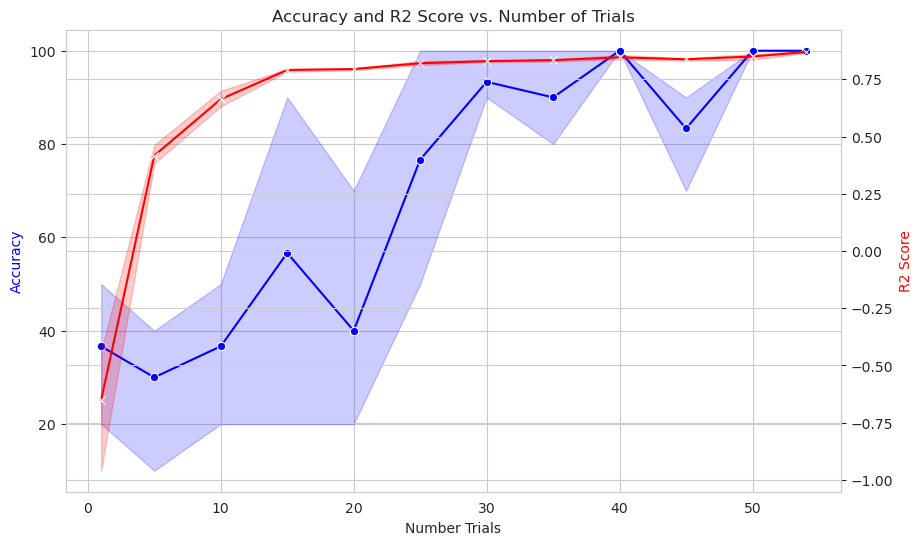

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Initialize the seaborn style
sns.set_style("whitegrid")

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the accuracy on the primary y-axis
sns.lineplot(data=df, x='Number Trials', y='Accuracy Task Detector', ax=ax1, marker='o', color='b')
ax1.set_ylabel('Accuracy', color='b')

# Create the secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=df, x='Number Trials', y='R2 Task Detector', ax=ax2, marker='x', color='r')
ax2.set_ylabel('R2 Score', color='r')

# Add title
plt.title('Accuracy and R2 Score vs. Number of Trials')

# Show plot
plt.show()


### Check here how many trials are needed for a task to be detected once it has been pre-trained.

In [25]:
path_to_hnets = './Models/Models_HNET'
experiment_name = 'Experiment18'
data_path = './Data/Sim_Data_'+experiment_name+'.pkl'
with open(os.path.join(data_path), 'rb') as fp:
    data = pickle.load(fp)

In [26]:
data.keys()

dict_keys(['Data_4_2', 'Data_1_1', 'Data_0_2', 'Data_1_2', 'Data_0_1', 'Data_3_1', 'Data_4_1', 'Data_2_1', 'Data_2_2', 'Data_3_2'])

In [27]:
_,_,_,_,x_test_task2, y_test_task2 = data['Data_0_1']
_,_,_,_,x_test_task1, y_test_task1 = data['Data_1_2']
_,_,_,_,x_test_task4, y_test_task4 = data['Data_2_2']
_,_,_,_,x_test_task3, y_test_task3 = data['Data_3_2']
_,_,_,_,x_test_task0, y_test_task0 = data['Data_4_1']

In [28]:
X = [x_test_task0, x_test_task1, x_test_task2, x_test_task3, x_test_task4]
Y = [y_test_task0, y_test_task1, y_test_task2, y_test_task3, y_test_task4]
num_trials_ = [1,2,4,6,8,10,12,14,16,17]
path_to_detectors ='./Models/Models_Task_Recognition'
models_exp = np.sort(os.listdir(os.path.join(path_to_detectors, experiment_name)))
thrs = 0.8

task_ids = []
random_trials = []
r2_list = []
true_ids = []
num_trials = []

In [29]:
true_id = 0
for feats, targs in zip(X,Y):
    for n in num_trials_:
        for t in range(10):
            trials = random.sample(range(17),n)
            x, y = feats[trials, :,:], targs[trials, :,:]
            r2_task = []
            for m in (models_exp):
                model_i = torch.load(os.path.join(path_to_detectors,experiment_name, m))
                y_true_test, y_pred_test = reshape_to_eval(x,y, model_i)
                r2_task.append(r2_score(y_true_test,y_pred_test))
            max_r2 = max(r2_task)
            r2_list.append(max_r2)
            task_id = None
            if max_r2 > thrs:
                task_id = np.argmax(r2_task)
            task_ids.append(task_id)
            random_trials.append(t)
            num_trials.append(n)
            true_ids.append(true_id)
    true_id += 1

In [30]:
df_3 = pd.DataFrame({"Trial":random_trials, "Num Trials": num_trials, 
                     "True Task": true_ids, 
                    "Predicted Task" : task_ids,
                     "R2":r2_list })

In [31]:
df_3

,Trial,Num Trials,True Task,Predicted Task,R2
0,0,1,0,NaN,-0.166788
1,1,1,0,NaN,0.161042
2,2,1,0,0.0,0.877104
3,3,1,0,NaN,0.184164
4,4,1,0,NaN,0.161042
...,...,...,...,...,...
495,5,17,4,4.0,0.850405
496,6,17,4,4.0,0.850405
497,7,17,4,4.0,0.850405
498,8,17,4,4.0,0.850405


In [32]:
accuracy_by_num_trials = df_3.groupby(['Num Trials', 'True Task']).apply(lambda group: (group['True Task'] == group['Predicted Task']).mean())
accuracy_by_num_trials.name = 'Accuracy'

In [33]:
df_4 = pd.DataFrame(accuracy_by_num_trials.reset_index())

In [34]:
df_3 = df_3.merge(df_4, on = ['Num Trials', 'True Task'])

In [35]:
df_3.columns

Index(['Trial', 'Num Trials', 'True Task', 'Predicted Task', 'R2', 'Accuracy'], dtype='object')

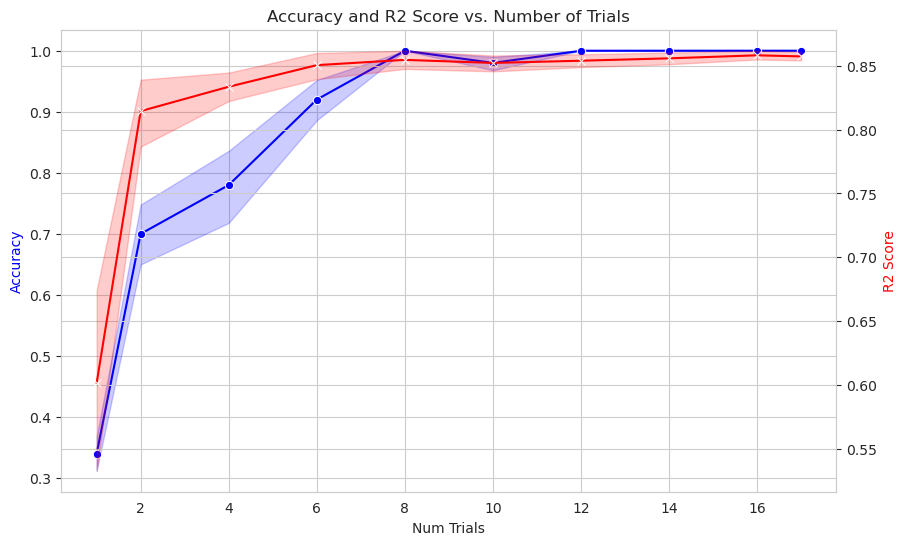

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Initialize the seaborn style
sns.set_style("whitegrid")

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the accuracy on the primary y-axis
sns.lineplot(data=df_3, x='Num Trials', y='Accuracy', ax=ax1, marker='o', color='b')
ax1.set_ylabel('Accuracy', color='b')

# Create the secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=df_3, x='Num Trials', y='R2', ax=ax2, marker='x', color='r')
ax2.set_ylabel('R2 Score', color='r')

# Add title
plt.title('Accuracy and R2 Score vs. Number of Trials')

# Show plot
plt.show()